<a href="https://colab.research.google.com/github/MehrdadJalali-AI/RecommenderSystems/blob/main/GraphCB_MovieRecommender_NodeVectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧩 Graph-Based Movie Recommender System (Colab-Compatible with nodevectors)
**Professor Dr. Mehrdad Jalali**  
SRH University Heidelberg  

This notebook demonstrates a **graph-based content recommender** using **Node2Vec** from the `nodevectors` library.  
It builds a movie similarity graph based on genres, learns embeddings for each node, and visualizes clusters of related movies.

---

## 🎯 Objectives
- Represent movies as **nodes** and connect them by **genre similarity**
- Learn **graph embeddings** using `Node2Vec` (`nodevectors`)
- Recommend similar movies based on **embedding similarity**
- Visualize graph clusters for interpretability

**Learning Links:** Slides 45–47 (Graph-Based CB Models and GNNs)


In [2]:

!pip install -q pandas scikit-learn networkx matplotlib seaborn nodevectors


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 51.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 25.6.0 requires networkx>=3.2, but you have networkx 2.5.1 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.5.1 which is incompatible.


In [3]:

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from nodevectors import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from networkx.algorithms import community



## 📂 Load MovieLens Dataset
We reuse the **MovieLens** dataset used in the TF-IDF and SBERT practicals.


In [4]:

# Load MovieLens metadata
movies_url = "https://raw.githubusercontent.com/MehrdadJalali-AI/RecommenderSystems/main/Datasets/ml-latest-small/movies.csv"
movies = pd.read_csv(movies_url)
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



## 🔧 Data Preprocessing
We split genres into lists, encode them, and compute pairwise **genre similarity** to form graph edges.


In [5]:

movies["genres"] = movies["genres"].fillna("").apply(lambda x: x.split("|"))
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies["genres"])

# Compute cosine similarity
sim_matrix = cosine_similarity(genre_matrix)

# Create edges for similarity > 0.6
edges = []
threshold = 0.6
for i in range(len(movies)):
    for j in range(i + 1, len(movies)):
        if sim_matrix[i, j] > threshold:
            edges.append((movies.iloc[i]["movieId"], movies.iloc[j]["movieId"], sim_matrix[i, j]))

len(edges)


6458958


## 🕸️ Build Movie Graph
Nodes represent movies; edges connect movies with **high genre similarity (> 0.6)**.


In [7]:
import networkx as nx
import pandas as pd

G = nx.Graph()

for _, row in movies.iterrows():
    G.add_node(row["movieId"], title=row["title"])

G.add_weighted_edges_from(edges)

# Replacement for nx.info(G)
print("Graph Information:")
print(f"Type: {type(G).__name__}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Is directed: {G.is_directed()}")

# Optional: show first few nodes and edges
print("\nSample nodes with attributes:")
for n, data in list(G.nodes(data=True))[:5]:
    print(f"  {n}: {data}")

print("\nSample edges with weights:")
for u, v, data in list(G.edges(data=True))[:5]:
    print(f"  ({u}, {v}) weight={data['weight']}")



Graph Information:
Type: Graph
Number of nodes: 9742
Number of edges: 6458958
Is directed: False

Sample nodes with attributes:
  1: {'title': 'Toy Story (1995)'}
  2: {'title': 'Jumanji (1995)'}
  3: {'title': 'Grumpier Old Men (1995)'}
  4: {'title': 'Waiting to Exhale (1995)'}
  5: {'title': 'Father of the Bride Part II (1995)'}

Sample edges with weights:
  (1, 2) weight=0.7745966692414835
  (1, 8) weight=0.6324555320336758
  (1, 13) weight=0.7745966692414835
  (1, 38) weight=0.6324555320336758
  (1, 54) weight=0.6324555320336758



## 🧠 Learn Node Embeddings using Node2Vec (`nodevectors`)
We train a **Node2Vec** model to generate embeddings that represent each movie’s structural relationships.


In [9]:
import gensim

# Monkey-patch gensim 4.x to be backward compatible with nodevectors
if not hasattr(gensim.models, "Word2Vec"):
    from gensim.models.word2vec import Word2Vec
    gensim.models.Word2Vec = Word2Vec

orig_init = gensim.models.Word2Vec.__init__

def patched_init(self, *args, **kwargs):
    # Map old parameter names to new ones
    if "size" in kwargs and "vector_size" not in kwargs:
        kwargs["vector_size"] = kwargs.pop("size")
    if "iter" in kwargs and "epochs" not in kwargs:
        kwargs["epochs"] = kwargs.pop("iter")
    orig_init(self, *args, **kwargs)

gensim.models.Word2Vec.__init__ = patched_init


# --- rest of your Node2Vec code ---
import networkx as nx
import pandas as pd
from nodevectors import Node2Vec
import csrgraph as cg
from scipy.sparse import csr_matrix

# assuming G is already built
adj_array = nx.to_scipy_sparse_array(G, dtype=float)
adj_matrix = csr_matrix(adj_array)
csr_G = cg.csrgraph(adj_matrix, nodenames=list(G.nodes()))

node2vec = Node2Vec(
    n_components=64,
    walklen=20,
    epochs=5,
    return_weight=1.0,
    neighbor_weight=1.0,
    threads=2
)
node2vec.fit(csr_G)

embeddings = node2vec.model.wv
embedding_df = pd.DataFrame(
    [embeddings[str(node)] for node in G.nodes()],
    index=list(G.nodes())
)

print(embedding_df.head())



Making walks... Done, T=7.23
Mapping Walk Names... Done, T=0.66
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=27.38
         0         1         2         3         4         5         6   \
1  0.074581 -0.691517  0.503934  1.144015  0.392222 -1.024485  0.296067   
2  0.425561 -0.532406  0.306011  1.069532  0.378043 -0.836969  0.236455   
3 -0.028990 -0.505689  1.087099  0.769539 -0.353960  0.220619 -0.388630   
4  0.148093 -0.341235  1.028980 -0.075293 -0.709053  0.916437 -0.203578   
5  0.027396 -0.450212  0.715420  0.821746  0.109638 -0.312724 -0.540615   

         7         8         9   ...        54        55        56        57  \
1  1.061395 -0.224074  0.588820  ...  0.142044 -1.593963 -0.700727 -0.238281   
2  0.643036 -0.412375  0.406467  ...  0.320993 -1.233227 -0.681986 -0.428023   
3  0.514109 -0.300884  0.543346  ...  0.182802 -1.104194 -0.138444 -0.191136   
4 -0.260533 -0.69558


## 🎬 Recommend Similar Movies
We recommend top-N similar movies using **cosine similarity** between Node2Vec embeddings.


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# --- Compute cosine similarity matrix
embed_sim = cosine_similarity(embedding_df)

# --- Helper mappings
id_to_idx = {mid: i for i, mid in enumerate(embedding_df.index)}
idx_to_id = {i: mid for mid, i in id_to_idx.items()}

# --- Recommendation function
def recommend_graph(title, top_n=5):
    # find movie ID from title
    match = movies[movies["title"].str.contains(title, case=False, na=False)]
    if match.empty:
        print("No movie found with that title.")
        return []
    movie_id = match.iloc[0]["movieId"]

    if movie_id not in id_to_idx:
        print("Movie not found in embedding index.")
        return []

    # compute similarities
    sim_scores = list(enumerate(embed_sim[id_to_idx[movie_id]]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # build clean list of recommendations
    recs = []
    for i, score in sim_scores:
        title = movies.loc[movies["movieId"] == idx_to_id[i], "title"].values[0]
        recs.append((title, round(float(score), 3)))  # convert np.float32 → float

    # pretty print
    print(f"\n🎬 Top {top_n} similar movies to '{match.iloc[0]['title']}':\n")
    for rank, (rec_title, sim) in enumerate(recs, start=1):
        print(f"{rank}. {rec_title}  —  similarity: {sim}")

    return recs


# --- Example usage
recommend_graph("Toy Story")




🎬 Top 5 similar movies to 'Toy Story (1995)':

1. Asterix and the Vikings (Astérix et les Vikings) (2006)  —  similarity: 0.996
2. Shrek the Third (2007)  —  similarity: 0.995
3. American Tail, An (1986)  —  similarity: 0.994
4. Adventures of Rocky and Bullwinkle, The (2000)  —  similarity: 0.994
5. Moana (2016)  —  similarity: 0.992


[('Asterix and the Vikings (Astérix et les Vikings) (2006)', 0.996),
 ('Shrek the Third (2007)', 0.995),
 ('American Tail, An (1986)', 0.994),
 ('Adventures of Rocky and Bullwinkle, The (2000)', 0.994),
 ('Moana (2016)', 0.992)]


## 🎨 Enhanced Graph Visualization – with Clusters and Labels
We visualize a subset of the movie graph, showing clusters of related movies.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


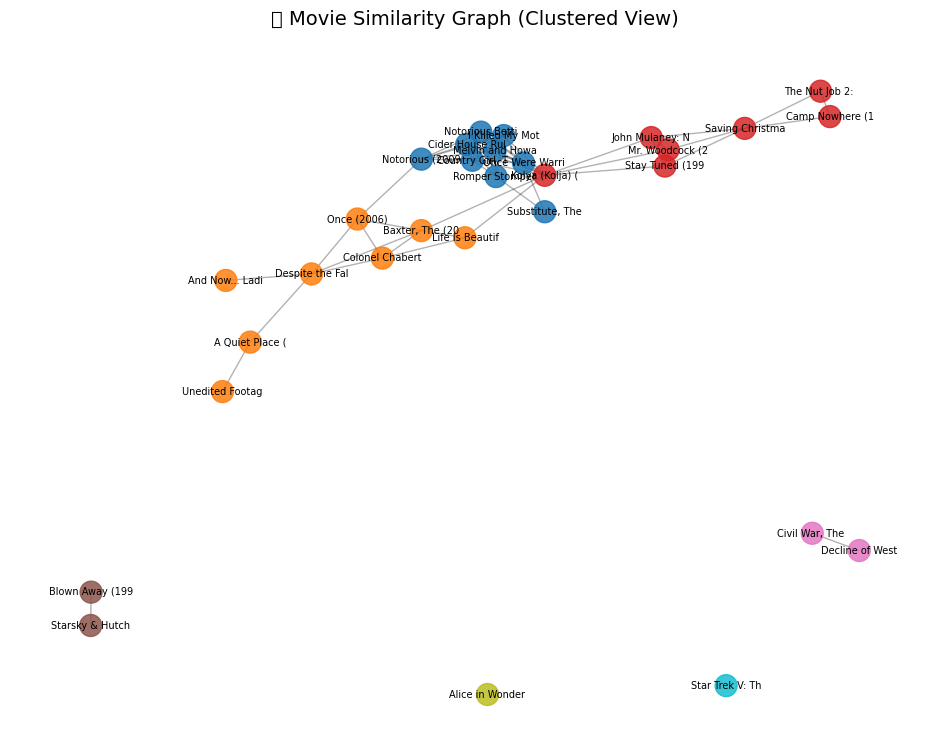

In [12]:

# Sample a small connected subgraph for clarity
subset_nodes = list(movies.sample(30, random_state=42)["movieId"])
subgraph = G.subgraph(subset_nodes).copy()

# Compute layout
pos = nx.spring_layout(subgraph, seed=42)

# Detect communities (clusters)
communities = list(community.greedy_modularity_communities(subgraph))
color_map = {}
for i, com in enumerate(communities):
    for node in com:
        color_map[node] = i

# Assign colors based on clusters
node_colors = [color_map.get(node, 0) for node in subgraph.nodes()]

# Plot
plt.figure(figsize=(12, 9))
nx.draw_networkx_nodes(subgraph, pos, node_size=250, cmap=plt.cm.tab10,
                       node_color=node_colors, alpha=0.85)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
nx.draw_networkx_labels(subgraph, pos,
                        labels={n: movies.loc[movies['movieId']==n, 'title'].values[0][:15] for n in subgraph.nodes()},
                        font_size=7)

plt.title("🎬 Movie Similarity Graph (Clustered View)", fontsize=14)
plt.axis("off")
plt.show()



## 🧩 Discussion
- The **graph-based recommender** models **structural similarities** among movies.  
- **Node2Vec embeddings** capture **neighborhood context**, enabling better relational recommendations.  
- The visualization reveals **clusters** of semantically related movies.  
- This model complements TF-IDF and SBERT by incorporating **network topology**.  

---
**Next Step:** Extend this approach using **Graph Neural Networks (GNNs)** such as **GraphSAGE** or **GCN** for end-to-end graph learning.
